# Data Cleaning For Mapping

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('gene_channel_labels.csv')
print(df)

     Metadata_Symbol  GeneID (EntrezGene)           Mito             ER  \
0                A2M                    2       Positive  Inteterminate   
1            A3GALT2               127550  Inteterminate       Positive   
2             A4GALT                53947       Positive       Positive   
3              A4GNT                51146       Positive  Inteterminate   
4               AACS                65985       Positive       Positive   
...              ...                  ...            ...            ...   
7970         ZSCAN32                54925  Inteterminate  Inteterminate   
7971          ZSCAN4               201516       Positive       Positive   
7972         ZSCAN5A                79149       Positive       Positive   
7973          ZSCAN9                 7746       Positive       Positive   
7974          ZSWIM2               151112       Positive       Positive   

                RNA            AGP            DNA  
0     Inteterminate       Negative       Positi

In [3]:
gene_id = df['GeneID (EntrezGene)']
Mito = df['Mito']
ER = df['ER']
RNA = df['RNA']
AGP = df['AGP']
DNA = df['DNA']
new_df = pd.DataFrame({'GeneID (EntrezGene)': gene_id, 'Mito': Mito, 'ER': ER, 'RNA': RNA, 'AGP': AGP, 'DNA': DNA})
print(new_df)
all_genes_df = new_df.to_excel('all_genes_ids_channels.xlsx', index=False)

      GeneID (EntrezGene)           Mito             ER            RNA  \
0                       2       Positive  Inteterminate  Inteterminate   
1                  127550  Inteterminate       Positive       Positive   
2                   53947       Positive       Positive       Positive   
3                   51146       Positive  Inteterminate       Positive   
4                   65985       Positive       Positive  Inteterminate   
...                   ...            ...            ...            ...   
7970                54925  Inteterminate  Inteterminate  Inteterminate   
7971               201516       Positive       Positive       Positive   
7972                79149       Positive       Positive       Positive   
7973                 7746       Positive       Positive       Positive   
7974               151112       Positive       Positive       Positive   

                AGP            DNA  
0          Negative       Positive  
1          Positive       Positive  


In [4]:
uniprot_df = pd.read_excel("HUMAN_9606_idmapping.xlsx")

In [5]:
cleaned_rows = []
for index, row in uniprot_df.iterrows():
    gene_ids = str(row["GeneID (EntrezGene)"]).split(";")
    for gene_id in gene_ids:
        new_row = row.copy()
        new_row["GeneID (EntrezGene)"] = gene_id.strip()
        cleaned_rows.append(new_row)

In [6]:
cleaned_df = pd.DataFrame(cleaned_rows)

In [7]:
cleaned_df = cleaned_df[cleaned_df["GeneID (EntrezGene)"] != "nan"].reset_index(drop=True)

In [8]:
updated_uniprot = pd.DataFrame(cleaned_df)
updated_uniprot.to_excel("CleanedDataForMappingChannels.xlsx", index=False)

# Mapping Script

In [9]:
uniprot_df = pd.read_excel("CleanedDataForMappingChannels.xlsx")
all_genes_df = pd.read_excel("all_genes_ids_channels.xlsx")

In [10]:
gene_to_protein = {}
for gene_id in all_genes_df['GeneID (EntrezGene)']:
    
    # Check if the gene_id exists in uniprot_df
    matching_proteins = uniprot_df[uniprot_df['GeneID (EntrezGene)'] == gene_id]['UniProtKB-ID'].tolist()
    
    # Add the mapping to the dictionary
    gene_to_protein[gene_id] = matching_proteins

In [11]:
matched_rows = pd.DataFrame(columns=uniprot_df.columns)

In [12]:
# Iterate over the rows of CleanedDataForMapping
for index, row in uniprot_df.iterrows():
    gene_id = row['GeneID (EntrezGene)']
    protein_id = row['UniProtKB-ID']
    
    # Check if gene ID and protein ID match with the dictionary
    if gene_id in gene_to_protein and protein_id in gene_to_protein[gene_id]:
        # Add the entire row to the matched_rows DataFrame
        matched_rows = pd.concat([matched_rows, pd.DataFrame(row).transpose()], ignore_index=True)

In [13]:
matched_rows = matched_rows.sort_values('GeneID (EntrezGene)')
matched_rows = matched_rows.rename(columns={'Unnamed: 6': 'GO Terms'})

In [14]:
matched_rows = pd.merge(matched_rows, all_genes_df[['GeneID (EntrezGene)', 'Mito', 'ER', 'RNA', 'AGP', 'DNA']], on='GeneID (EntrezGene)', how='left')
print(matched_rows)

      UniProtKB-AC  UniProtKB-ID GeneID (EntrezGene)  \
0           P01023    A2MG_HUMAN                   2   
1           F5H5R8  F5H5R8_HUMAN                   9   
2           Q400J6  Q400J6_HUMAN                   9   
3           P18440    ARY1_HUMAN                   9   
4           P11245    ARY2_HUMAN                  10   
...            ...           ...                 ...   
14835       Q02080   MEF2B_HUMAN           100271849   
14836       Q9Y575    ASB3_HUMAN           100302652   
14837       P35226    BMI1_HUMAN           100532731   
14838       R4GMX3  R4GMX3_HUMAN           100532731   
14839       Q9Y3D8    KAD6_HUMAN           102157402   

                                              Unnamed: 3  \
0      NP_000005.2; NP_001334352.1; NP_001334353.1; N...   
1      NP_001153647.1; NP_001153648.1; NP_001278891.1...   
2      NP_001153642.1; NP_001153644.1; NP_001153645.1...   
3      NP_000653.3; NP_001153642.1; NP_001153643.1; N...   
4                          

In [15]:
matched_rows.to_excel("CleanedDataForFeatureVectorsChannels.xlsx", index=False)

# Feature Vectors

In [16]:
import numpy as np
import matplotlib.pyplot as plt

feature_vector_data = pd.read_excel("CleanedDataForFeatureVectorsChannels.xlsx")
cleaned_rows = []

# Iterate over each row in the original DataFrame
for index, row in feature_vector_data.iterrows():
    terms = str(row["GO Terms"]).split(";")  # Split gene IDs by semicolon
    for term in terms:
        # Check if the label is "Indeterminate" and skip the row
        if row["Mito"] == "Inteterminate" or row["ER"] == "Inteterminate" or row["RNA"] == "Inteterminate" or row["AGP"] == "Inteterminate" or row["DNA"] == "Inteterminate":
            continue

        # Create a new row with the separated gene ID and add to list
        new_row = row.copy()
        new_row["GO Terms"] = term.strip()
        cleaned_rows.append(new_row)
# Create a new DataFrame with the cleaned rows
cleaned_df = pd.DataFrame(cleaned_rows)
cleaned_df.to_excel("CleanedDataForAnc2vecChannels.xlsx", index=False)

print(cleaned_df)

      UniProtKB-AC  UniProtKB-ID  GeneID (EntrezGene)  \
1           F5H5R8  F5H5R8_HUMAN                    9   
2           Q400J6  Q400J6_HUMAN                    9   
3           P18440    ARY1_HUMAN                    9   
3           P18440    ARY1_HUMAN                    9   
3           P18440    ARY1_HUMAN                    9   
...            ...           ...                  ...   
14835       Q02080   MEF2B_HUMAN            100271849   
14835       Q02080   MEF2B_HUMAN            100271849   
14835       Q02080   MEF2B_HUMAN            100271849   
14835       Q02080   MEF2B_HUMAN            100271849   
14835       Q02080   MEF2B_HUMAN            100271849   

                                              Unnamed: 3  \
1      NP_001153647.1; NP_001153648.1; NP_001278891.1...   
2      NP_001153642.1; NP_001153644.1; NP_001153645.1...   
3      NP_000653.3; NP_001153642.1; NP_001153643.1; N...   
3      NP_000653.3; NP_001153642.1; NP_001153643.1; N...   
3      NP_00065

In [17]:
term_dictionary = {}
for term in cleaned_df["GO Terms"]:
    if term in term_dictionary:
        term_dictionary[term] = term_dictionary[term] + 1
    else:
        term_dictionary[term] = 1

sorted_dict = dict(sorted(term_dictionary.items(), key=lambda x: x[1], reverse=True))


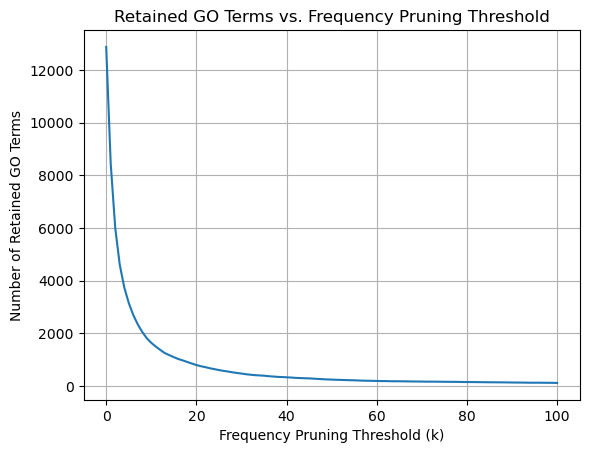

In [18]:
thresholds = np.arange(0,101,1)

num_retained_terms = []
for threshold in thresholds:
    retained_terms = [term for term, freq in term_dictionary.items() if freq > threshold]
    num_retained_terms.append(len(retained_terms))

# Plot the results
plt.plot(thresholds, num_retained_terms)
plt.xlabel("Frequency Pruning Threshold (k)")
plt.ylabel("Number of Retained GO Terms")
plt.title("Retained GO Terms vs. Frequency Pruning Threshold")
plt.grid(True)
plt.savefig('FrequencyGraph.png', bbox_inches='tight', dpi=600)
plt.show()

In [19]:
threshold_value = 5


# Create a new dictionary with values above the threshold
new_dict = {key: value for key, value in sorted_dict.items() if value > threshold_value}


go_terms = list(new_dict.keys())

print(len(go_terms))

# Create a DataFrame with the GO terms
df = pd.DataFrame({"GO Terms": go_terms})

# Save the DataFrame to a CSV file
df.to_excel("go_terms_channels.xlsx", index=False)

3148


In [20]:
feature_vectors = []

for index, row in cleaned_df.iterrows():
    gene_id = row['GeneID (EntrezGene)']
    uniprot_ac = row['UniProtKB-AC']
    Mito = row["Mito"]
    ER = row["ER"]
    RNA = row["RNA"]
    AGP = row["AGP"]
    DNA = row["DNA"]
    go_term = row['GO Terms']

    gene_entry = next((gene for gene in feature_vectors if gene['gene_id'] == gene_id and gene['uniprot_ac'] == uniprot_ac and gene["Mito"] == Mito and gene["ER"] == ER and gene["RNA"] == RNA and gene["AGP"] == AGP and gene["DNA"] == DNA), None)

    if gene_entry is None:
        gene_entry = {'gene_id': gene_id, 'uniprot_ac': uniprot_ac, "Mito" : Mito, "ER" : ER, "RNA" : RNA, "AGP" : AGP, "DNA" : DNA, 'feature_vector': [0] * len(go_terms)}
        feature_vectors.append(gene_entry)

    for i, term in enumerate(go_terms):
        if term == go_term:
            gene_entry['feature_vector'][i] = 1


In [21]:
data = [[gene_entry['uniprot_ac'], gene_entry['gene_id'], gene_entry['Mito'], gene_entry['ER'], gene_entry['RNA'], gene_entry['AGP'], gene_entry['DNA']] + gene_entry['feature_vector'] for gene_entry in feature_vectors]
CleanedDataForMachineLearning = pd.DataFrame(data, columns=['UniprotAC', 'GeneID', 'Mito', 'ER', 'RNA', 'AGP', 'DNA'] + go_terms)
CleanedDataForMachineLearning[go_terms] = CleanedDataForMachineLearning[go_terms].astype(int).reset_index(drop=True)
print(CleanedDataForMachineLearning)

       UniprotAC     GeneID      Mito        ER       RNA       AGP       DNA  \
0         F5H5R8          9  Positive  Negative  Negative  Negative  Negative   
1         Q400J6          9  Positive  Negative  Negative  Negative  Negative   
2         P18440          9  Positive  Negative  Negative  Negative  Negative   
3         F1T0I5         15  Positive  Positive  Positive  Positive  Positive   
4         Q16613         15  Positive  Positive  Positive  Positive  Positive   
...          ...        ...       ...       ...       ...       ...       ...   
8018      P0CG40  100131390  Positive  Positive  Positive  Positive  Positive   
8019  A0A1X9RU27  100132074  Positive  Positive  Positive  Positive  Positive   
8020      B7U540  100134444  Positive  Positive  Positive  Positive  Positive   
8021  A0A024R7K5  100271849  Positive  Positive  Positive  Positive  Positive   
8022      Q02080  100271849  Positive  Positive  Positive  Positive  Positive   

      GO:0005634  GO:000582

# Machine Learning

In [22]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, LabelEncoder

In [23]:
X = [data['feature_vector'] for data in list(feature_vectors)]

Mito_Y = CleanedDataForMachineLearning['Mito'].tolist()
ER_Y = CleanedDataForMachineLearning['ER'].tolist()
RNA_Y = CleanedDataForMachineLearning['RNA'].tolist()
AGP_Y = CleanedDataForMachineLearning['AGP'].tolist()
DNA_Y = CleanedDataForMachineLearning['DNA'].tolist()

In [24]:
columns = ['position#' + str(i + 1) for i in range(len(X[0]))]

binary_vectors = pd.DataFrame(X, columns=columns)

binary_vectors.insert(0, "Mito", Mito_Y)
binary_vectors.insert(1, "ER", ER_Y)
binary_vectors.insert(2, "RNA", RNA_Y)
binary_vectors.insert(3, "AGP", AGP_Y)
binary_vectors.insert(4, "DNA", DNA_Y)


binary_vectors.to_excel('OntologyChannelsMachineLearning.xlsx', index=False)

In [25]:
label_encoder = LabelEncoder()
y_binary_mito = label_encoder.fit_transform(Mito_Y)
y_binary_er = label_encoder.fit_transform(ER_Y)
y_binary_rna = label_encoder.fit_transform(RNA_Y)
y_binary_agp = label_encoder.fit_transform(AGP_Y)
y_binary_dna = label_encoder.fit_transform(DNA_Y)

In [26]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [27]:
random_forest = RandomForestClassifier()

In [28]:
rf_probs_mito = cross_val_predict(random_forest, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]
rf_fpr_mito, rf_tpr_mito, _ = roc_curve(y_binary_mito, rf_probs_mito)
rf_auc_mito = auc(rf_fpr_mito, rf_tpr_mito)

In [29]:
rf_probs_er = cross_val_predict(random_forest, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]
rf_fpr_er, rf_tpr_er, _ = roc_curve(y_binary_er, rf_probs_er)
rf_auc_er = auc(rf_fpr_er, rf_tpr_er)

In [30]:
rf_probs_rna = cross_val_predict(random_forest, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]
rf_fpr_rna, rf_tpr_rna, _ = roc_curve(y_binary_rna, rf_probs_rna)
rf_auc_rna = auc(rf_fpr_rna, rf_tpr_rna)

In [31]:
rf_probs_agp = cross_val_predict(random_forest, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]

rf_fpr_agp, rf_tpr_agp, _ = roc_curve(y_binary_agp, rf_probs_agp)
rf_auc_agp = auc(rf_fpr_agp, rf_tpr_agp)

In [32]:
rf_probs_dna = cross_val_predict(random_forest, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]

rf_fpr_dna, rf_tpr_dna, _ = roc_curve(y_binary_dna, rf_probs_dna)
rf_auc_dna = auc(rf_fpr_dna, rf_tpr_dna)

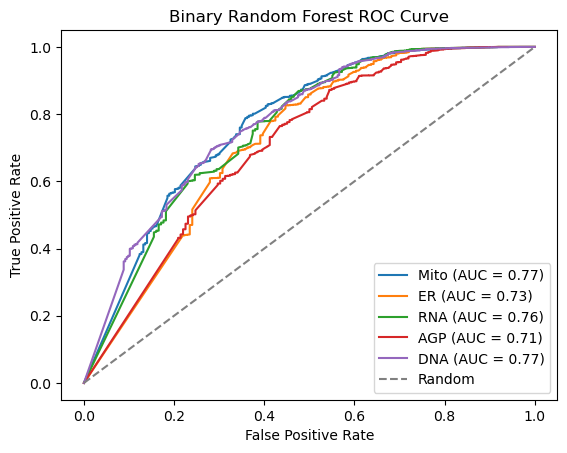

In [33]:
plt.plot(rf_fpr_mito, rf_tpr_mito, label=f'Mito (AUC = {rf_auc_mito:.2f})')
plt.plot(rf_fpr_er, rf_tpr_er, label=f'ER (AUC = {rf_auc_er:.2f})')
plt.plot(rf_fpr_rna, rf_tpr_rna, label=f'RNA (AUC = {rf_auc_rna:.2f})')
plt.plot(rf_fpr_agp, rf_tpr_agp, label=f'AGP (AUC = {rf_auc_agp:.2f})')
plt.plot(rf_fpr_dna, rf_tpr_dna, label=f'DNA (AUC = {rf_auc_dna:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Random Forest ROC Curve')
plt.legend()
plt.savefig('BinaryRandomForest.png', bbox_inches='tight')
plt.show()

In [34]:
logistic_regression = LogisticRegression()

In [35]:
lr_probs_mito = cross_val_predict(logistic_regression, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]

lr_fpr_mito, lr_tpr_mito, _ = roc_curve(y_binary_mito, lr_probs_mito)
lr_auc_mito = auc(lr_fpr_mito, lr_tpr_mito)

In [36]:
lr_probs_er = cross_val_predict(logistic_regression, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]

lr_fpr_er, lr_tpr_er, _ = roc_curve(y_binary_er, lr_probs_er)
lr_auc_er = auc(lr_fpr_er, lr_tpr_er)

In [37]:
lr_probs_rna = cross_val_predict(logistic_regression, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]

lr_fpr_rna, lr_tpr_rna, _ = roc_curve(y_binary_rna, lr_probs_rna)
lr_auc_rna = auc(lr_fpr_rna, lr_tpr_rna)

In [38]:
lr_probs_agp = cross_val_predict(logistic_regression, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]

lr_fpr_agp, lr_tpr_agp, _ = roc_curve(y_binary_agp, lr_probs_agp)
lr_auc_agp = auc(lr_fpr_agp, lr_tpr_agp)

In [39]:
lr_probs_dna = cross_val_predict(logistic_regression, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]

lr_fpr_dna, lr_tpr_dna, _ = roc_curve(y_binary_dna, lr_probs_dna)
lr_auc_dna = auc(lr_fpr_dna, lr_tpr_dna)

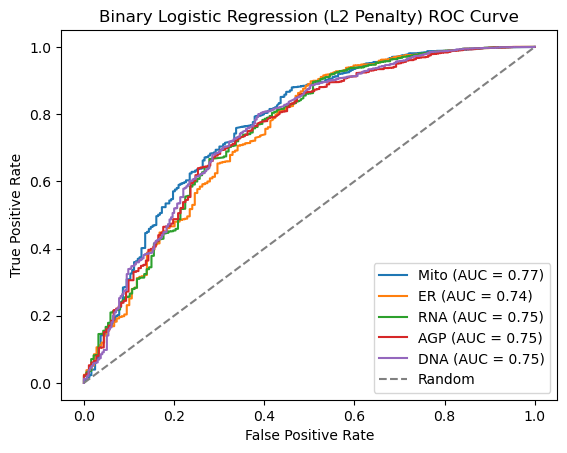

In [40]:
plt.plot(lr_fpr_mito, lr_tpr_mito, label=f'Mito (AUC = {lr_auc_mito:.2f})')
plt.plot(lr_fpr_er, lr_tpr_er, label=f'ER (AUC = {lr_auc_er:.2f})')
plt.plot(lr_fpr_rna, lr_tpr_rna, label=f'RNA (AUC = {lr_auc_rna:.2f})')
plt.plot(lr_fpr_agp, lr_tpr_agp, label=f'AGP (AUC = {lr_auc_agp:.2f})')
plt.plot(lr_fpr_dna, lr_tpr_dna, label=f'DNA (AUC = {lr_auc_dna:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Logistic Regression (L2 Penalty) ROC Curve')
plt.legend()
plt.savefig('BinaryLogisticRegression.png',bbox_inches='tight')
plt.show()

In [42]:
ridge_regression = Ridge()

In [43]:
ridge_probs_mito = cross_val_predict(ridge_regression, X, y_binary_mito, cv=cv)

ridge_fpr_mito, ridge_tpr_mito, _ = roc_curve(y_binary_mito, ridge_probs_mito)
ridge_auc_mito = auc(ridge_fpr_mito, ridge_tpr_mito)

In [44]:
ridge_probs_er = cross_val_predict(ridge_regression, X, y_binary_er, cv=cv)

ridge_fpr_er, ridge_tpr_er, _ = roc_curve(y_binary_er, ridge_probs_er)
ridge_auc_er = auc(ridge_fpr_er, ridge_tpr_er)

In [45]:
ridge_probs_rna = cross_val_predict(ridge_regression, X, y_binary_rna, cv=cv)

ridge_fpr_rna, ridge_tpr_rna, _ = roc_curve(y_binary_rna, ridge_probs_rna)
ridge_auc_rna = auc(ridge_fpr_rna, ridge_tpr_rna)

In [46]:
ridge_probs_agp = cross_val_predict(ridge_regression, X, y_binary_agp, cv=cv)

ridge_fpr_agp, ridge_tpr_agp, _ = roc_curve(y_binary_agp, ridge_probs_agp)
ridge_auc_agp = auc(ridge_fpr_agp, ridge_tpr_agp)

In [47]:
ridge_probs_dna = cross_val_predict(ridge_regression, X, y_binary_dna, cv=cv)

ridge_fpr_dna, ridge_tpr_dna, _ = roc_curve(y_binary_dna, ridge_probs_dna)
ridge_auc_dna = auc(ridge_fpr_dna, ridge_tpr_dna)

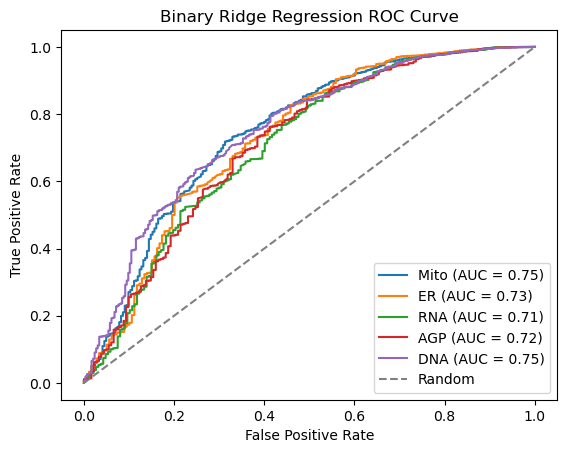

In [48]:
plt.plot(ridge_fpr_mito, ridge_tpr_mito, label=f'Mito (AUC = {ridge_auc_mito:.2f})')
plt.plot(ridge_fpr_er, ridge_tpr_er, label=f'ER (AUC = {ridge_auc_er:.2f})')
plt.plot(ridge_fpr_rna, ridge_tpr_rna, label=f'RNA (AUC = {ridge_auc_rna:.2f})')
plt.plot(ridge_fpr_agp, ridge_tpr_agp, label=f'AGP (AUC = {ridge_auc_agp:.2f})')
plt.plot(ridge_fpr_dna, ridge_tpr_dna, label=f'DNA (AUC = {ridge_auc_dna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Ridge Regression ROC Curve')
plt.legend()
plt.savefig('BinaryRidgeRegression.png', bbox_inches='tight')
plt.show()

In [58]:
L1 = LogisticRegression(penalty = 'l1', solver = 'liblinear')

In [59]:
l1_probs_mito = cross_val_predict(L1, X, y_binary_mito, cv=cv, method='predict_proba')[:, 1]

l1_fpr_mito, l1_tpr_mito, _ = roc_curve(y_binary_mito, l1_probs_mito)
l1_auc_mito = auc(l1_fpr_mito, l1_tpr_mito)

In [60]:
l1_probs_er = cross_val_predict(L1, X, y_binary_er, cv=cv, method='predict_proba')[:, 1]

l1_fpr_er, l1_tpr_er, _ = roc_curve(y_binary_er, l1_probs_er)
l1_auc_er = auc(l1_fpr_er, l1_tpr_er)

In [61]:
l1_probs_rna = cross_val_predict(L1, X, y_binary_rna, cv=cv, method='predict_proba')[:, 1]

l1_fpr_rna, l1_tpr_rna, _ = roc_curve(y_binary_rna, l1_probs_rna)
l1_auc_rna = auc(l1_fpr_rna, l1_tpr_rna)

In [62]:
l1_probs_agp = cross_val_predict(L1, X, y_binary_agp, cv=cv, method='predict_proba')[:, 1]

l1_fpr_agp, l1_tpr_agp, _ = roc_curve(y_binary_agp, l1_probs_agp)
l1_auc_agp = auc(l1_fpr_agp, l1_tpr_agp)

In [63]:
l1_probs_dna = cross_val_predict(L1, X, y_binary_dna, cv=cv, method='predict_proba')[:, 1]

l1_fpr_dna, l1_tpr_dna, _ = roc_curve(y_binary_dna, l1_probs_dna)
l1_auc_dna = auc(l1_fpr_dna, l1_tpr_dna)

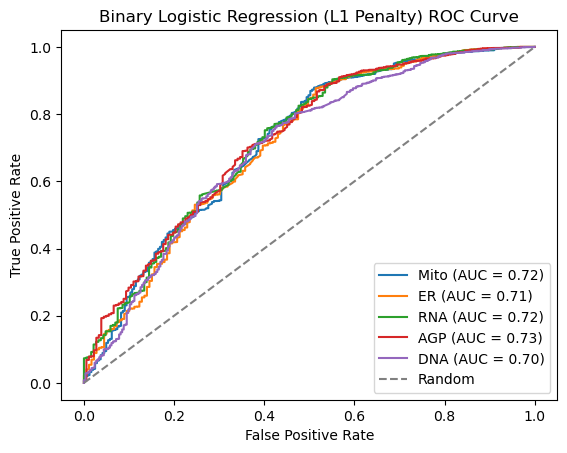

In [64]:
plt.plot(l1_fpr_mito, l1_tpr_mito, label=f'Mito (AUC = {l1_auc_mito:.2f})')
plt.plot(l1_fpr_er, l1_tpr_er, label=f'ER (AUC = {l1_auc_er:.2f})')
plt.plot(l1_fpr_rna, l1_tpr_rna, label=f'RNA (AUC = {l1_auc_rna:.2f})')
plt.plot(l1_fpr_agp, l1_tpr_agp, label=f'AGP (AUC = {l1_auc_agp:.2f})')
plt.plot(l1_fpr_dna, l1_tpr_dna, label=f'DNA (AUC = {l1_auc_dna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Logistic Regression (L1 Penalty) ROC Curve')
plt.legend()
plt.savefig('BinaryL1.png', bbox_inches='tight')
plt.show()

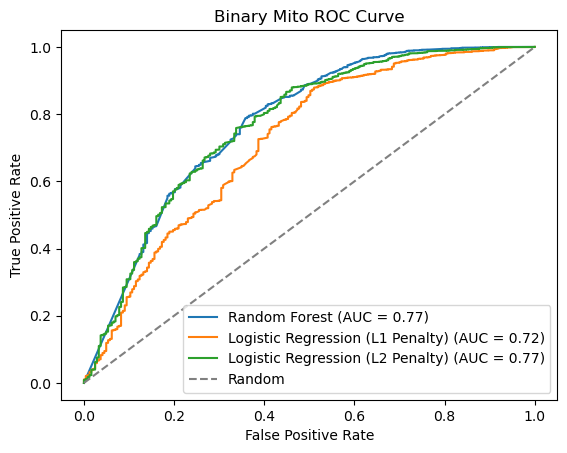

In [70]:
plt.plot(rf_fpr_mito, rf_tpr_mito, label=f'Random Forest (AUC = {rf_auc_mito:.2f})')
plt.plot(l1_fpr_mito, l1_tpr_mito, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_mito:.2f})')
plt.plot(lr_fpr_mito, lr_tpr_mito, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_mito:.2f})')
#plt.plot(ridge_fpr_mito, ridge_tpr_mito, label=f'Ridge Regression(AUC = {ridge_auc_mito:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Mito ROC Curve')
plt.legend()
plt.savefig('BinaryMito.png',bbox_inches='tight')
plt.show()

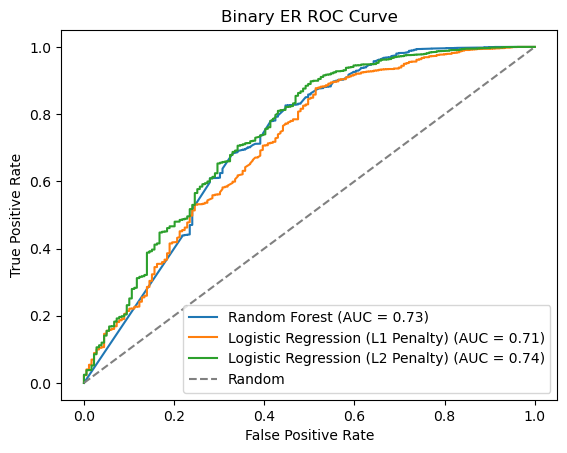

In [71]:
plt.plot(rf_fpr_er, rf_tpr_er, label=f'Random Forest (AUC = {rf_auc_er:.2f})')
plt.plot(l1_fpr_er, l1_tpr_er, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_er:.2f})')
plt.plot(lr_fpr_er, lr_tpr_er, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_er:.2f})')
#plt.plot(ridge_fpr_er, ridge_tpr_er, label=f'Ridge Regression(AUC = {ridge_auc_er:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ER ROC Curve')
plt.legend()
plt.savefig('BinaryER.png', bbox_inches='tight')
plt.show()

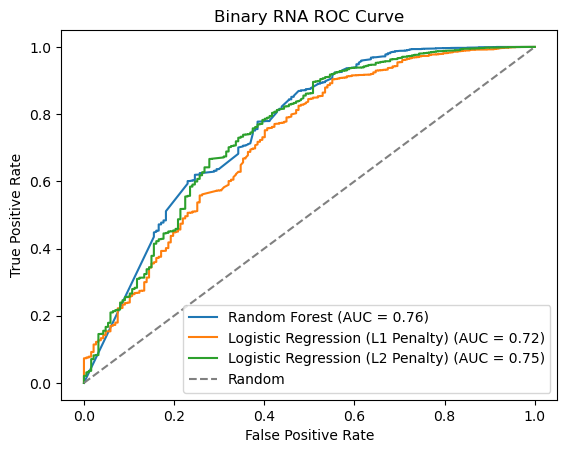

In [72]:
plt.plot(rf_fpr_rna, rf_tpr_rna, label=f'Random Forest (AUC = {rf_auc_rna:.2f})')
plt.plot(l1_fpr_rna, l1_tpr_rna, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_rna:.2f})')
plt.plot(lr_fpr_rna, lr_tpr_rna, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_rna:.2f})')
#plt.plot(ridge_fpr_rna, ridge_tpr_rna, label=f'Ridge Regression (AUC = {ridge_auc_rna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary RNA ROC Curve')
plt.legend()
plt.savefig('BinaryRNA.png',bbox_inches='tight')
plt.show()

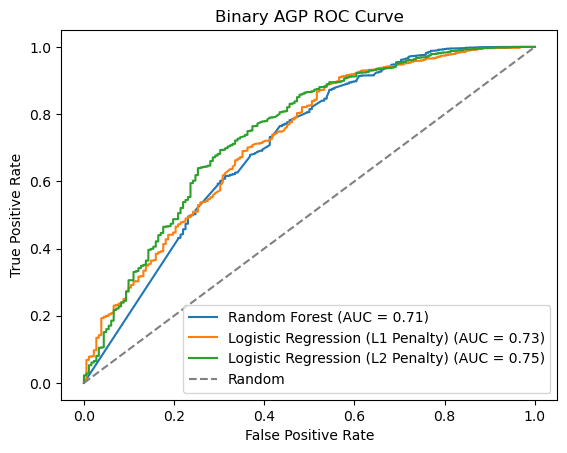

In [73]:
plt.plot(rf_fpr_agp, rf_tpr_agp, label=f'Random Forest (AUC = {rf_auc_agp:.2f})')
plt.plot(l1_fpr_agp, l1_tpr_agp, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_agp:.2f})')
plt.plot(lr_fpr_agp, lr_tpr_agp, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_agp:.2f})')
#plt.plot(ridge_fpr_agp, ridge_tpr_agp, label=f'Ridge Regression (AUC = {ridge_auc_agp:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary AGP ROC Curve')
plt.legend()

plt.savefig('BinaryAGP.png',bbox_inches='tight', facecolor='white', transparent=False, dpi=600)

plt.show()

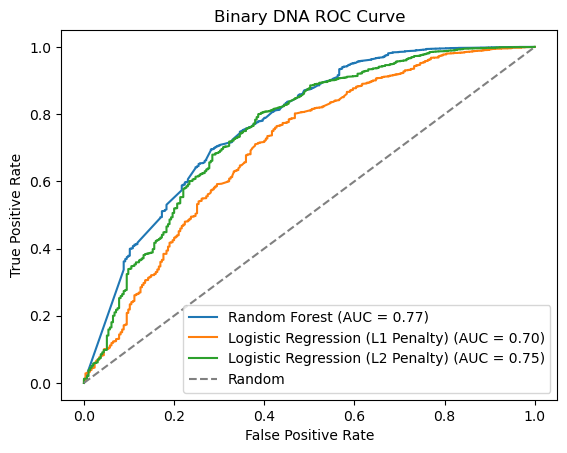

In [74]:
plt.plot(rf_fpr_dna, rf_tpr_dna, label=f'Random Forest (AUC = {rf_auc_dna:.2f})')
plt.plot(l1_fpr_dna, l1_tpr_dna, label=f'Logistic Regression (L1 Penalty) (AUC = {l1_auc_dna:.2f})')
plt.plot(lr_fpr_dna, lr_tpr_dna, label=f'Logistic Regression (L2 Penalty) (AUC = {lr_auc_dna:.2f})')
#plt.plot(ridge_fpr_dna, ridge_tpr_dna, label=f'Ridge Regression (AUC = {ridge_auc_dna:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary DNA ROC Curve')
plt.legend()
plt.savefig('BinaryDNA.png',bbox_inches='tight')
plt.show()